In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict
import pandas as pd
from tqdm.notebook import tqdm
import random

In [6]:
analysis_dir = Path("analysis")
layer = 11
head = 15

In [25]:
def load_analyzed_chunks(analysis_dir: Path) -> List[Dict]:
    """
    Load all analyzed chunks from the analysis directory.
    
    Args:
        analysis_dir: Path to the analysis directory
        
    Returns:
        List of dictionaries containing chunk data
    """
    all_chunks = []
    
    # Iterate through all problem directories
    for problem_dir in tqdm([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Load chunks_analyzed.json if it exists
            chunks_file = seed_dir / "chunks.json"
            if chunks_file.exists():
                with open(chunks_file, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Add problem_id and seed to each chunk
                for chunk in chunks_data:
                    chunk['problem_id'] = problem_id
                    chunk['seed'] = seed
                    chunk['relative_position'] = chunk['index'] / len(chunks_data)
                
                all_chunks.extend([chunk for chunk in chunks_data if chunk['category'] != 'Unknown'])
    
    return all_chunks

# Load all analyzed chunks
all_chunks = load_analyzed_chunks(analysis_dir)
print(f"Loaded {len(all_chunks)} chunks from {len(set(chunk['problem_id'] for chunk in all_chunks))} problems")

  0%|          | 0/162 [00:00<?, ?it/s]

Loaded 25348 chunks from 126 problems


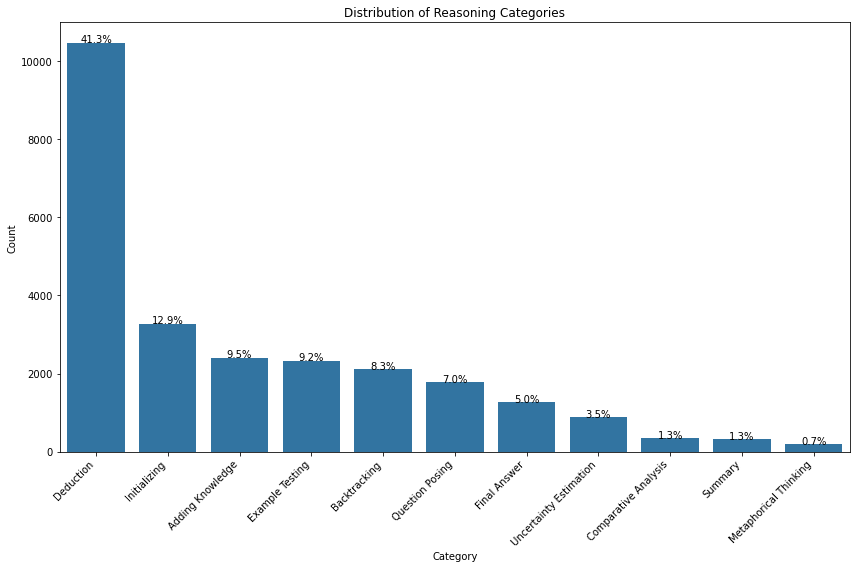

In [27]:
def plot_category_distribution(chunks: List[Dict]):
    """
    Plot the distribution of reasoning categories.
    
    Args:
        chunks: List of chunk dictionaries
    """
    # Count categories
    categories = [chunk['category'] for chunk in chunks]
    category_counts = Counter(categories)
    
    # Sort by frequency
    sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Create DataFrame for plotting
    df = pd.DataFrame(sorted_categories, columns=['Category', 'Count'])
    
    # Calculate percentage
    total = sum(df['Count'])
    df['Percentage'] = df['Count'] / total * 100
    
    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Category', y='Count', data=df)
    
    # Add percentage labels
    for i, row in enumerate(df.itertuples()):
        ax.text(i, row.Count + 5, f"{row.Percentage:.1f}%", ha='center')
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Reasoning Categories')
    plt.tight_layout()
    plt.show()
    
    return df

category_distribution = plot_category_distribution(all_chunks)

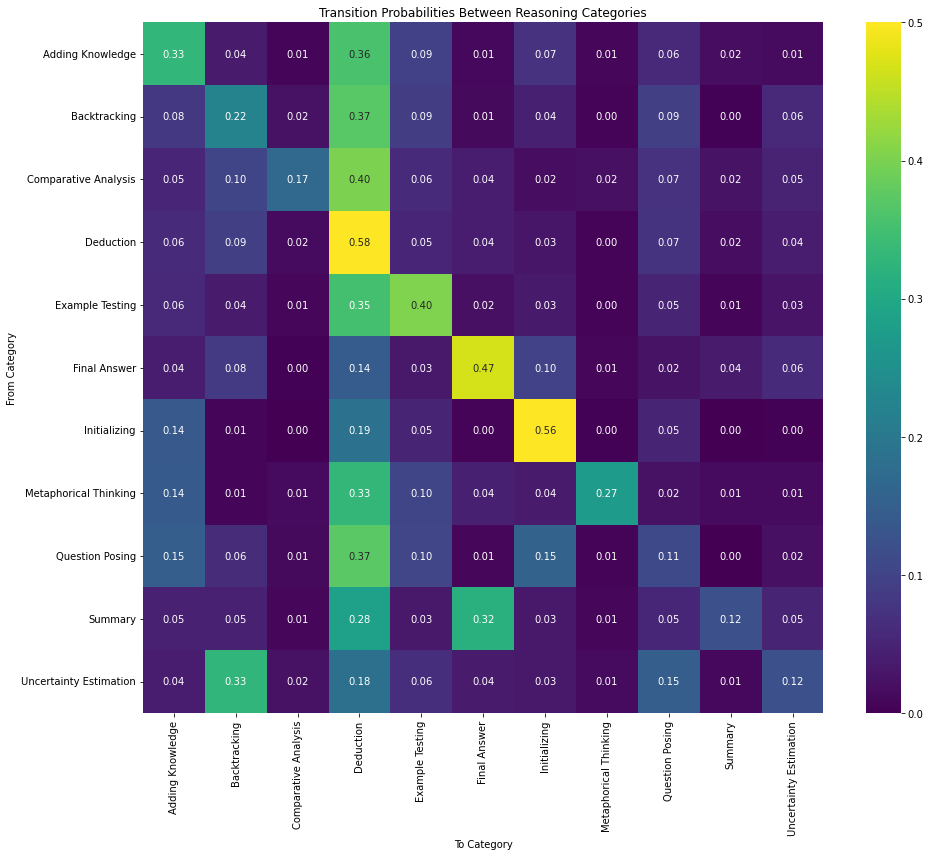

In [9]:
def compute_transition_matrix(chunks: List[Dict]):
    """
    Compute transition matrix between reasoning categories.
    
    Args:
        chunks: List of chunk dictionaries
        
    Returns:
        Transition matrix as DataFrame
    """
    # Get unique categories
    categories = sorted(set(chunk['category'] for chunk in chunks))
    
    # Initialize transition counts
    transitions = defaultdict(Counter)
    
    # Group chunks by problem and seed
    problem_chunks = defaultdict(list)
    for chunk in chunks:
        key = (chunk['problem_id'], chunk['seed'])
        problem_chunks[key].append(chunk)
    
    # Count transitions within each problem
    for key, chunks in problem_chunks.items():
        # Sort chunks by index
        sorted_chunks = sorted(chunks, key=lambda x: x['index'])
        
        # Count transitions
        for i in range(len(sorted_chunks) - 1):
            from_cat = sorted_chunks[i]['category']
            to_cat = sorted_chunks[i + 1]['category']
            transitions[from_cat][to_cat] += 1
    
    # Create transition matrix
    matrix = []
    for from_cat in categories:
        row = []
        total = sum(transitions[from_cat].values())
        for to_cat in categories:
            # Calculate probability if total > 0
            prob = transitions[from_cat][to_cat] / total if total > 0 else 0
            row.append(prob)
        matrix.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(matrix, index=categories, columns=categories)
    
    return df

def plot_transition_matrix(transition_matrix: pd.DataFrame):
    """
    Plot transition matrix as heatmap.
    
    Args:
        transition_matrix: Transition matrix as DataFrame
    """
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        transition_matrix, 
        annot=True, 
        cmap='viridis', 
        vmin=0, 
        vmax=0.5,  # Cap at 0.5 for better color distribution
        fmt='.2f'
    )
    plt.title('Transition Probabilities Between Reasoning Categories')
    plt.xlabel('To Category')
    plt.ylabel('From Category')
    plt.tight_layout()
    plt.show()

# Compute and plot transition matrix
transition_matrix = compute_transition_matrix(all_chunks)
plot_transition_matrix(transition_matrix)

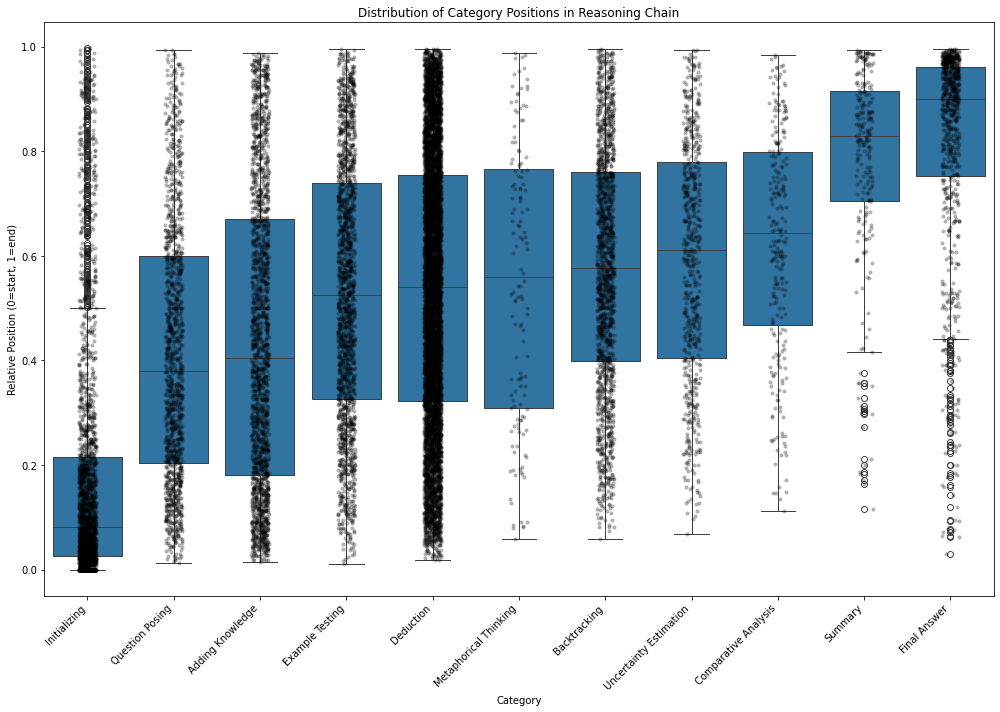

In [10]:
def analyze_category_positions(chunks: List[Dict]):
    """
    Analyze the relative positions of each category in the reasoning chain.
    
    Args:
        chunks: List of chunk dictionaries
        
    Returns:
        DataFrame with position statistics for each category
    """
    # Group by category
    category_positions = defaultdict(list)
    
    for chunk in chunks:
        category = chunk['category']
        position = chunk['relative_position']
        category_positions[category].append(position)
    
    # Calculate statistics
    stats = []
    for category, positions in category_positions.items():
        stats.append({
            'Category': category,
            'Count': len(positions),
            'Mean Position': np.mean(positions),
            'Std Dev': np.std(positions),
            'Min': np.min(positions),
            'Max': np.max(positions),
            '25%': np.percentile(positions, 25),
            '50%': np.percentile(positions, 50),
            '75%': np.percentile(positions, 75)
        })
    
    # Create DataFrame
    df = pd.DataFrame(stats)
    df = df.sort_values('Mean Position')
    
    return df

def plot_category_positions(chunks: List[Dict]):
    """
    Plot the distribution of category positions in the reasoning chain.
    
    Args:
        chunks: List of chunk dictionaries
    """
    # Group by category
    category_positions = defaultdict(list)
    
    for chunk in chunks:
        category = chunk['category']
        position = chunk['relative_position']
        category_positions[category].append(position)
    
    # Create DataFrame for plotting
    data = []
    for category, positions in category_positions.items():
        for pos in positions:
            data.append({'Category': category, 'Relative Position': pos})
    
    df = pd.DataFrame(data)
    
    # Sort categories by mean position
    category_order = df.groupby('Category')['Relative Position'].mean().sort_values().index
    
    # Plot
    plt.figure(figsize=(14, 10))
    
    # Box plot
    ax = sns.boxplot(
        x='Category', 
        y='Relative Position', 
        data=df, 
        order=category_order
    )
    
    # Add scatter points for individual data points
    sns.stripplot(
        x='Category', 
        y='Relative Position', 
        data=df, 
        order=category_order,
        size=4, 
        color='black', 
        alpha=0.3
    )
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Category Positions in Reasoning Chain')
    plt.ylabel('Relative Position (0=start, 1=end)')
    plt.tight_layout()
    plt.show()
    
    # Return statistics
    return analyze_category_positions(chunks)

# Analyze and plot category positions
position_stats = plot_category_positions(all_chunks)

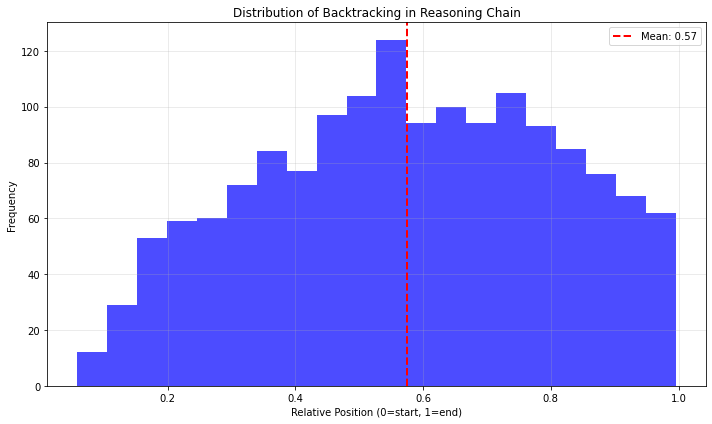

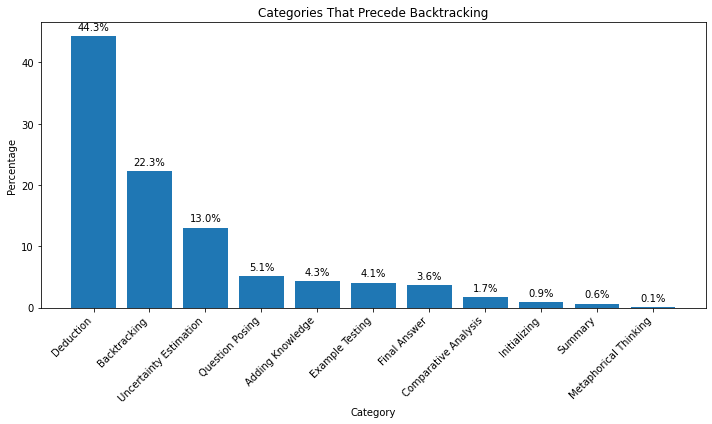

In [11]:
def analyze_backtracking(chunks: List[Dict]):
    """
    Analyze when backtracking occurs in the reasoning chain.
    
    Args:
        chunks: List of chunk dictionaries
    """
    # Filter for backtracking chunks
    backtracking_chunks = [chunk for chunk in chunks if chunk['category'] == 'Backtracking']
    
    if not backtracking_chunks:
        print("No backtracking chunks found in the dataset.")
        return
    
    # Get positions
    positions = [chunk['relative_position'] for chunk in backtracking_chunks]
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(positions, bins=20, alpha=0.7, color='blue')
    plt.axvline(np.mean(positions), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(positions):.2f}')
    
    plt.title('Distribution of Backtracking in Reasoning Chain')
    plt.xlabel('Relative Position (0=start, 1=end)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    # print(f"Backtracking Statistics:")
    # print(f"  Count: {len(backtracking_chunks)}")
    # print(f"  Mean Position: {np.mean(positions):.3f}")
    # print(f"  Std Dev: {np.std(positions):.3f}")
    # print(f"  Min: {np.min(positions):.3f}")
    # print(f"  Max: {np.max(positions):.3f}")
    
    # What categories typically precede backtracking?
    preceding_categories = []
    
    # Group chunks by problem and seed
    problem_chunks = defaultdict(list)
    for chunk in chunks:
        key = (chunk['problem_id'], chunk['seed'])
        problem_chunks[key].append(chunk)
    
    # Find categories that precede backtracking
    for key, prob_chunks in problem_chunks.items():
        # Sort chunks by index
        sorted_chunks = sorted(prob_chunks, key=lambda x: x['index'])
        
        # Find backtracking chunks
        for i, chunk in enumerate(sorted_chunks):
            if chunk['category'] == 'Backtracking' and i > 0:
                preceding_categories.append(sorted_chunks[i-1]['category'])
    
    # Count preceding categories
    preceding_counts = Counter(preceding_categories)
    
    # Plot
    plt.figure(figsize=(10, 6))
    categories, counts = zip(*preceding_counts.most_common())
    
    # Calculate percentages
    total = sum(counts)
    percentages = [count/total*100 for count in counts]
    
    # Create bars
    bars = plt.bar(categories, percentages)
    
    # Add percentage labels
    for bar, percentage in zip(bars, percentages):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1,
            f"{percentage:.1f}%",
            ha='center'
        )
    
    plt.title('Categories That Precede Backtracking')
    plt.xlabel('Category')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analyze backtracking
analyze_backtracking(all_chunks)

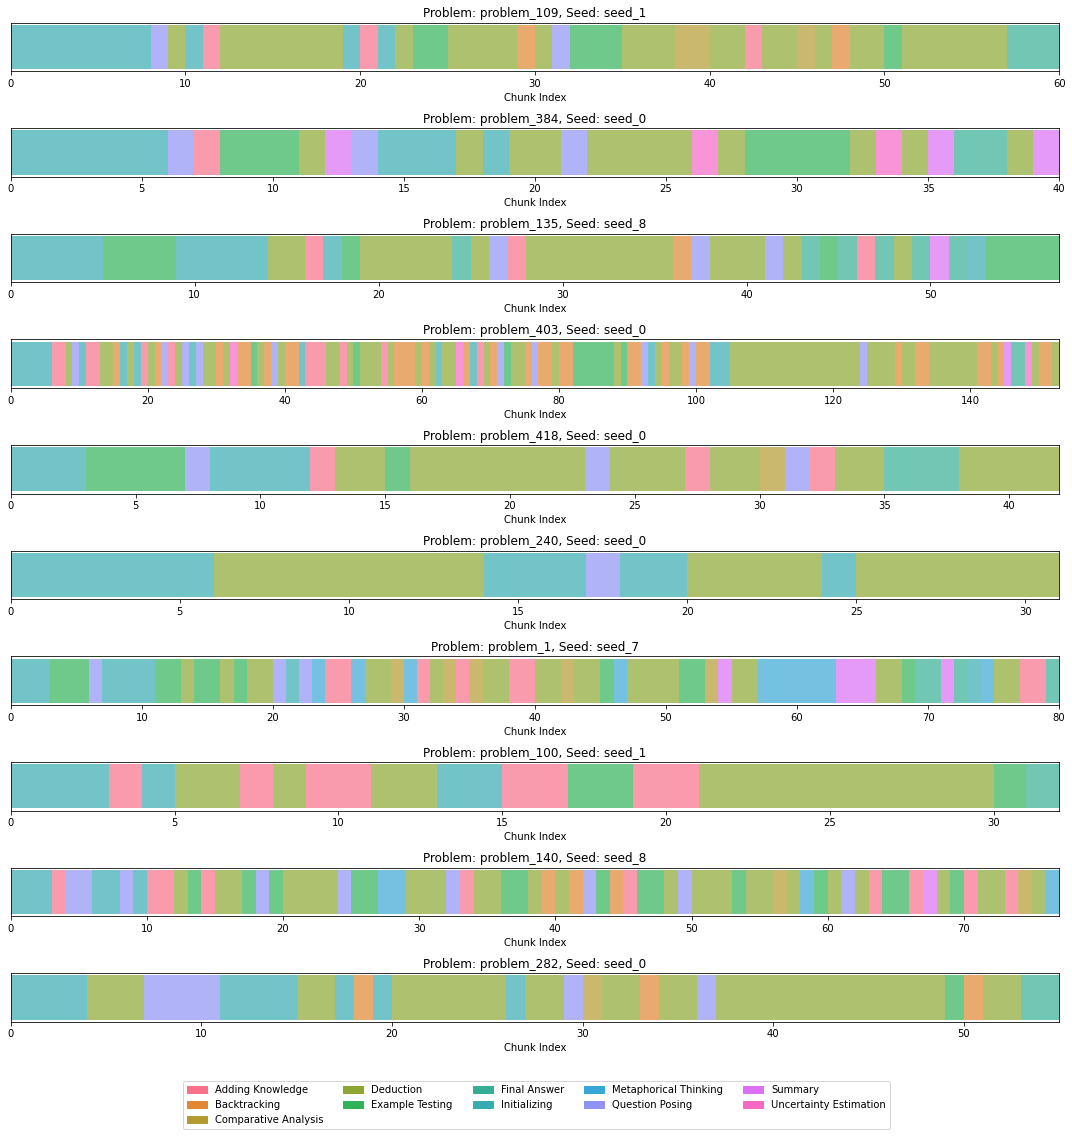

In [12]:
def visualize_category_sequences(chunks: List[Dict], max_problems: int = 10):
    """
    Visualize the sequence of categories for each problem.
    
    Args:
        chunks: List of chunk dictionaries
        max_problems: Maximum number of problems to visualize
    """
    # Get unique categories and assign colors
    categories = sorted(set(chunk['category'] for chunk in chunks))
    color_map = dict(zip(categories, sns.color_palette("husl", len(categories))))
    
    # Group chunks by problem and seed
    problem_chunks = defaultdict(list)
    for chunk in chunks:
        key = (chunk['problem_id'], chunk['seed'])
        problem_chunks[key].append(chunk)
    
    # Select a subset of problems
    selected_problems = random.sample(list(problem_chunks.keys()), max_problems)
    
    # Create figure
    fig, axes = plt.subplots(len(selected_problems), 1, figsize=(15, len(selected_problems) * 1.5))
    if len(selected_problems) == 1:
        axes = [axes]
    
    # Plot each problem
    for i, (key, ax) in enumerate(zip(selected_problems, axes)):
        problem_id, seed = key
        prob_chunks = sorted(problem_chunks[key], key=lambda x: x['index'])
        
        # Create colored blocks for each category
        for j, chunk in enumerate(prob_chunks):
            category = chunk['category']
            ax.barh(0, 1, left=j, color=color_map[category], alpha=0.7)
            
        # Set labels
        ax.set_yticks([])
        ax.set_xlabel('Chunk Index')
        ax.set_title(f'Problem: {problem_id}, Seed: {seed}')
        ax.set_xlim(0, len(prob_chunks))
    
    # Create legend
    handles = [plt.Rectangle((0,0),1,1, color=color_map[cat]) for cat in categories]
    fig.legend(handles, categories, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=min(5, len(categories)), frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

# Visualize category sequences
visualize_category_sequences(all_chunks)

In [ ]:
def analyze_cosine_vs_correlation(analysis_dir: Path):
    """
    Analyze the relationship between cosine similarity and Pearson correlation.
    
    Args:
        analysis_dir: Path to the analysis directory
    """
    # Store data for all problems
    all_data = []
    
    # Iterate through all problem directories
    for problem_dir in tqdm([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Check if both matrices exist
            cosine_path = seed_dir / f"chunk_cosine_similarity_layer_{layer}.npy"
            corr_path = seed_dir / f"chunk_correlation_layer_{layer}.npy"
            chunks_path = seed_dir / "chunks.json"
            
            if cosine_path.exists() and corr_path.exists() and chunks_path.exists():
                # Load matrices
                cosine_matrix = np.load(cosine_path)
                corr_matrix = np.load(corr_path)
                
                # Load chunk data
                with open(chunks_path, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Extract chunk categories
                categories = [chunk['category'] for chunk in chunks_data]
                abbreviations = [chunk['abbreviation'] for chunk in chunks_data]
                
                # Ensure matrices have the same shape
                if cosine_matrix.shape == corr_matrix.shape:
                    n = cosine_matrix.shape[0]
                    
                    # Extract all pairs (excluding self-comparisons)
                    for i in range(n):
                        for j in range(i+1, n):  # Only upper triangle
                            if categories[i] != 'Unknown' and categories[j] != 'Unknown':
                                all_data.append({
                                    'problem_id': problem_id,
                                    'seed': seed,
                                    'chunk_i': i,
                                    'chunk_j': j,
                                    'category_i': categories[i],
                                    'category_j': categories[j],
                                    'abbrev_i': abbreviations[i],
                                    'abbrev_j': abbreviations[j],
                                    'cosine_sim': cosine_matrix[i, j],
                                    'correlation': corr_matrix[i, j]
                                })
    
    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    
    return df

# Load and analyze cosine vs correlation data
cosine_corr_df = analyze_cosine_vs_correlation(analysis_dir)

# Plot the relationship
plt.figure(figsize=(10, 8))
plt.scatter(cosine_corr_df['cosine_sim'], cosine_corr_df['correlation'], alpha=0.5, s=10)

plt.xlabel('Cosine Similarity')
plt.ylabel('Pearson Correlation')
plt.title('Cosine Similarity vs Pearson Correlation for All Chunk Pairs')

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add a diagonal line for reference
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='red', linestyle='--', alpha=0.5, label='y=x')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation between cosine similarity and Pearson correlation
corr = cosine_corr_df['cosine_sim'].corr(cosine_corr_df['correlation'])
print(f"Correlation between cosine similarity and Pearson correlation: {corr:.3f}")

In [ ]:
def find_interesting_chunk_pairs(df: pd.DataFrame, n_pairs: int = 10):
    """
    Find interesting chunk pairs with:
    1. High cosine similarity but low correlation
    2. Low cosine similarity but high correlation
    
    Args:
        df: DataFrame with cosine similarity and correlation data
        n_pairs: Number of pairs to find in each category
        
    Returns:
        DataFrames with interesting pairs
    """
    # Calculate the difference between cosine similarity and correlation
    df['cos_minus_corr'] = df['cosine_sim'] - df['correlation']
    df['corr_minus_cos'] = df['correlation'] - df['cosine_sim']
    
    # Find pairs with high cosine but low correlation
    high_cos_low_corr = df[
        (df['cosine_sim'] > 0.7) &  # High cosine threshold
        (df['correlation'] < 0.3)    # Low correlation threshold
    ].sort_values('cos_minus_corr', ascending=False).head(n_pairs)
    
    # Find pairs with low cosine but high correlation
    low_cos_high_corr = df[
        (df['cosine_sim'] < 0.3) &   # Low cosine threshold
        (df['correlation'] > 0.7)     # High correlation threshold
    ].sort_values('corr_minus_cos', ascending=False).head(n_pairs)
    
    return high_cos_low_corr, low_cos_high_corr

def plot_interesting_pairs(df: pd.DataFrame):
    """
    Create a scatter plot highlighting interesting pairs.
    
    Args:
        df: DataFrame with cosine similarity and correlation data
    """
    # Find interesting pairs
    high_cos_low_corr, low_cos_high_corr = find_interesting_chunk_pairs(df)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    plt.scatter(
        df['cosine_sim'], 
        df['correlation'],
        alpha=0.2,
        s=10,
        color='gray',
        label='All pairs'
    )
    
    # Highlight high cosine, low correlation pairs
    plt.scatter(
        high_cos_low_corr['cosine_sim'],
        high_cos_low_corr['correlation'],
        alpha=1.0,
        s=100,
        color='red',
        marker='o',
        edgecolor='black',
        label='High cosine, low correlation'
    )
    
    # Highlight low cosine, high correlation pairs
    plt.scatter(
        low_cos_high_corr['cosine_sim'],
        low_cos_high_corr['correlation'],
        alpha=1.0,
        s=100,
        color='blue',
        marker='s',
        edgecolor='black',
        label='Low cosine, high correlation'
    )
    
    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--', alpha=0.5)
    
    # Add regions
    plt.axhspan(0.7, 1.0, xmax=0.3, alpha=0.1, color='blue', label='_nolegend_')
    plt.axvspan(0.7, 1.0, ymax=0.3, alpha=0.1, color='red', label='_nolegend_')
    
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Pearson Correlation')
    plt.title('Interesting Chunk Pairs: Divergent Cosine Similarity and Correlation')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return high_cos_low_corr, low_cos_high_corr

# Plot interesting pairs
high_cos_low_corr, low_cos_high_corr = plot_interesting_pairs(cosine_corr_df)

In [ ]:
def analyze_category_pairs(df: pd.DataFrame):
    """
    Analyze which category pairs tend to have high cosine but low correlation
    and which have low cosine but high correlation.
    
    Args:
        df: DataFrame with cosine similarity and correlation data
    """
    # Create category pair labels
    df['category_pair'] = df.apply(
        lambda row: f"{row['category_i']} → {row['category_j']}" 
        if row['category_i'] <= row['category_j'] 
        else f"{row['category_j']} → {row['category_i']}", 
        axis=1
    )
    
    # Define interesting pairs
    df['high_cos_low_corr'] = (df['cosine_sim'] > 0.7) & (df['correlation'] < 0.3)
    df['low_cos_high_corr'] = (df['cosine_sim'] < 0.3) & (df['correlation'] > 0.7)
    
    # Calculate percentages by category pair
    # First, get total counts for each category pair
    total_by_pair = df.groupby('category_pair').size()
    
    # Get counts of interesting pairs by category
    high_cos_low_corr_counts = df[df['high_cos_low_corr']].groupby('category_pair').size()
    low_cos_high_corr_counts = df[df['low_cos_high_corr']].groupby('category_pair').size()
    
    # Calculate percentages (only for pairs with at least 5 total occurrences)
    high_cos_low_corr_pct = pd.Series(index=total_by_pair.index, dtype=float)
    low_cos_high_corr_pct = pd.Series(index=total_by_pair.index, dtype=float)
    
    for pair in total_by_pair.index:
        if total_by_pair[pair] >= 5:  # Minimum threshold to avoid small sample size issues
            high_cos_low_corr_pct[pair] = high_cos_low_corr_counts.get(pair, 0) / total_by_pair[pair] * 100
            low_cos_high_corr_pct[pair] = low_cos_high_corr_counts.get(pair, 0) / total_by_pair[pair] * 100
    
    # Get top pairs by percentage
    top_high_cos_low_corr = high_cos_low_corr_pct.dropna().sort_values(ascending=False).head(20)
    top_low_cos_high_corr = low_cos_high_corr_pct.dropna().sort_values(ascending=False).head(20)
    
    # Create separate figures for each plot to avoid layout issues
    # Figure 1: High cosine, low correlation
    if not top_high_cos_low_corr.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_high_cos_low_corr.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_high_cos_low_corr.values, color='red', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_high_cos_low_corr.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with High Cosine, Low Correlation', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_high_cos_low_corr.iloc[0] if not top_high_cos_low_corr.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with high cosine, low correlation", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Figure 2: Low cosine, high correlation
    if not top_low_cos_high_corr.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_low_cos_high_corr.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_low_cos_high_corr.values, color='blue', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_low_cos_high_corr.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with Low Cosine, High Correlation', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_low_cos_high_corr.iloc[0] if not top_low_cos_high_corr.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with low cosine, high correlation", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Return both percentages and counts for reference
    high_cos_result = pd.DataFrame({'Percentage': top_high_cos_low_corr})
    
    if not top_high_cos_low_corr.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_high_cos_low_corr.index:
            counts.append(high_cos_low_corr_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        high_cos_result['Count'] = counts
        high_cos_result['Total'] = totals
    
    low_cos_result = pd.DataFrame({'Percentage': top_low_cos_high_corr})
    
    if not top_low_cos_high_corr.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_low_cos_high_corr.index:
            counts.append(low_cos_high_corr_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        low_cos_result['Count'] = counts
        low_cos_result['Total'] = totals
    
    return high_cos_result, low_cos_result

# Analyze category pairs
top_high_cos_low_corr, top_low_cos_high_corr = analyze_category_pairs(cosine_corr_df)

In [12]:
def load_chunk_text(problem_id, seed, chunk_idx, analysis_dir):
    """Load the text of a specific chunk."""
    chunks_file = analysis_dir / problem_id / seed / "chunks.json"
    if chunks_file.exists():
        with open(chunks_file, 'r', encoding='utf-8') as f:
            chunks_data = json.load(f)
            for chunk in chunks_data:
                if chunk['index'] == chunk_idx:
                    return chunk['text']
    return "Chunk text not found"

def display_example_pairs(high_cos_low_corr, low_cos_high_corr, analysis_dir, num_examples=10):
    """
    Display random examples of chunk pairs with interesting properties.
    
    Args:
        high_cos_low_corr: DataFrame with high cosine, low correlation pairs
        low_cos_high_corr: DataFrame with low cosine, high correlation pairs
        analysis_dir: Path to the analysis directory
        num_examples: Number of random examples to display
    """
    # Combine both types of examples
    all_examples = []
    
    if not high_cos_low_corr.empty:
        high_cos_samples = high_cos_low_corr.sample(min(num_examples // 2, len(high_cos_low_corr)))
        for _, row in high_cos_samples.iterrows():
            all_examples.append({
                'type': 'High Cosine, Low Correlation',
                'cosine_sim': row['cosine_sim'],
                'correlation': row['correlation'],
                'problem_id': row['problem_id'],
                'seed': row['seed'],
                'chunk_i': row['chunk_i'],
                'chunk_j': row['chunk_j'],
                'category_i': row['category_i'],
                'category_j': row['category_j']
            })
    
    if not low_cos_high_corr.empty:
        low_cos_samples = low_cos_high_corr.sample(min(num_examples // 2, len(low_cos_high_corr)))
        for _, row in low_cos_samples.iterrows():
            all_examples.append({
                'type': 'Low Cosine, High Correlation',
                'cosine_sim': row['cosine_sim'],
                'correlation': row['correlation'],
                'problem_id': row['problem_id'],
                'seed': row['seed'],
                'chunk_i': row['chunk_i'],
                'chunk_j': row['chunk_j'],
                'category_i': row['category_i'],
                'category_j': row['category_j']
            })
    
    # If we don't have enough examples, fill with more from whichever category has data
    remaining = num_examples - len(all_examples)
    if remaining > 0:
        if not high_cos_low_corr.empty and len(high_cos_low_corr) > len(high_cos_samples):
            additional = high_cos_low_corr.drop(high_cos_samples.index).sample(min(remaining, len(high_cos_low_corr) - len(high_cos_samples)))
            for _, row in additional.iterrows():
                all_examples.append({
                    'type': 'High Cosine, Low Correlation',
                    'cosine_sim': row['cosine_sim'],
                    'correlation': row['correlation'],
                    'problem_id': row['problem_id'],
                    'seed': row['seed'],
                    'chunk_i': row['chunk_i'],
                    'chunk_j': row['chunk_j'],
                    'category_i': row['category_i'],
                    'category_j': row['category_j']
                })
        elif not low_cos_high_corr.empty and len(low_cos_high_corr) > len(low_cos_samples):
            additional = low_cos_high_corr.drop(low_cos_samples.index).sample(min(remaining, len(low_cos_high_corr) - len(low_cos_samples)))
            for _, row in additional.iterrows():
                all_examples.append({
                    'type': 'Low Cosine, High Correlation',
                    'cosine_sim': row['cosine_sim'],
                    'correlation': row['correlation'],
                    'problem_id': row['problem_id'],
                    'seed': row['seed'],
                    'chunk_i': row['chunk_i'],
                    'chunk_j': row['chunk_j'],
                    'category_i': row['category_i'],
                    'category_j': row['category_j']
                })
    
    # Shuffle examples
    random.shuffle(all_examples)
    
    # Display examples
    for i, example in enumerate(all_examples[:num_examples], 1):
        print(f"\n--- Example {i}: {example['type']} ---")
        print(f"Cosine Similarity: {example['cosine_sim']:.3f}, Correlation: {example['correlation']:.3f}")
        print(f"Problem: {example['problem_id']}, Seed: {example['seed']}")
        print(f"Categories: {example['category_i']} → {example['category_j']}")
        
        text_i = load_chunk_text(example['problem_id'], example['seed'], example['chunk_i'], analysis_dir)
        text_j = load_chunk_text(example['problem_id'], example['seed'], example['chunk_j'], analysis_dir)
        
        print("\nChunk 1:")
        print(text_i[:300] + ("..." if len(text_i) > 300 else ""))
        
        print("\nChunk 2:")
        print(text_j[:300] + ("..." if len(text_j) > 300 else ""))
        print("-" * 80)

# Display 10 random examples
# display_example_pairs(high_cos_low_corr, low_cos_high_corr, analysis_dir, num_examples=10)

In [ ]:
def analyze_attention_vs_cosine(analysis_dir: Path):
    """
    Analyze the relationship between attention and cosine similarity.
    
    Args:
        analysis_dir: Path to the analysis directory
    """
    # Store data for all problems
    all_data = []
    
    # Iterate through all problem directories
    for problem_dir in tqdm([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Check if both matrices exist
            cosine_path = seed_dir / f"chunk_cosine_similarity_layer_{layer}.npy"
            attention_path = seed_dir / f"chunk_attention_layer_{layer}_head_{head}.npy"
            chunks_path = seed_dir / "chunks.json"
            
            if cosine_path.exists() and attention_path.exists() and chunks_path.exists():
                # Load matrices
                cosine_matrix = np.load(cosine_path)
                attention_matrix = np.load(attention_path)
                
                # Find the second maximum value after 1.0
                second_max = np.max(attention_matrix[attention_matrix < 1.0]) if np.any(attention_matrix < 1.0) else 0.05
                attention_matrix[attention_matrix >= 1.0] = second_max
                
                # Normalize attention matrix to [0, 1] range for each row
                # This ensures attention weights sum to 1 for each source chunk
                normalized_attention = np.zeros_like(attention_matrix)
                for i in range(len(attention_matrix)):
                    row_sum = attention_matrix[i].sum()
                    if row_sum > 0:
                        normalized_attention[i] = attention_matrix[i] / row_sum
                    
                # Ensure all values are between 0 and 1
                normalized_attention = np.clip(normalized_attention, 0, 1)
                
                # Load chunks data to get categories
                with open(chunks_path, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Extract categories
                categories = [chunk.get('category', 'Unknown') for chunk in chunks_data]
                
                # Get matrix dimensions
                n = len(cosine_matrix)
                
                # Collect data for each pair of chunks
                for i in range(1, n):
                    for j in range(0, i):  # Only lower triangle to avoid duplicates
                        all_data.append({
                            'problem_id': problem_id,
                            'seed': seed,
                            'chunk_i': i,
                            'chunk_j': j,
                            'category_i': categories[i],
                            'category_j': categories[j],
                            'cosine_sim': cosine_matrix[i, j],
                            'attention': normalized_attention[i, j],
                            'raw_attention': attention_matrix[i, j]
                        })
    
    # Convert to DataFrame
    attention_cosine_df = pd.DataFrame(all_data)
    
    # Plot scatter
    plt.figure(figsize=(10, 8))
    plt.scatter(
        attention_cosine_df['cosine_sim'], 
        attention_cosine_df['attention'],
        alpha=0.5,
        s=10
    )

    plt.xlabel('Cosine Similarity')
    plt.ylabel('Normalized Attention')
    plt.title('Cosine Similarity vs Normalized Attention for All Chunk Pairs')

    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--', alpha=0.5, label='y=x (perfect correlation)')

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate correlation between cosine similarity and attention
    corr = attention_cosine_df['cosine_sim'].corr(attention_cosine_df['attention'])
    print(f"Correlation between cosine similarity and normalized attention: {corr:.3f}")
    
    # Also show distribution of attention values
    plt.figure(figsize=(10, 6))
    plt.hist(attention_cosine_df['attention'], bins=50, alpha=0.7)
    plt.title('Distribution of Normalized Attention Values')
    plt.xlabel('Normalized Attention')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return attention_cosine_df

# Analyze attention vs cosine similarity
attention_cosine_df = analyze_attention_vs_cosine(analysis_dir)

In [ ]:
def find_interesting_attention_cosine_pairs(df: pd.DataFrame, n_pairs: int = 10):
    """
    Find interesting chunk pairs with:
    1. High cosine similarity but low attention
    2. Low cosine similarity but high attention
    
    Args:
        df: DataFrame with cosine similarity and normalized attention data
        n_pairs: Number of pairs to find in each category
        
    Returns:
        DataFrames with interesting pairs
    """
    # Define thresholds based on the distribution of normalized attention
    att_high_threshold = df['attention'].quantile(0.9)  # Top 10%
    att_low_threshold = df['attention'].quantile(0.1)   # Bottom 10%
    
    print(f"Attention thresholds - Low: {att_low_threshold:.3f}, High: {att_high_threshold:.3f}")
    
    # Calculate the difference between cosine similarity and attention
    df['cos_minus_att'] = df['cosine_sim'] - df['attention']
    df['att_minus_cos'] = df['attention'] - df['cosine_sim']
    
    # Find pairs with high cosine but low attention
    high_cos_low_att = df[
        (df['cosine_sim'] > 0.7) &                  # High cosine threshold
        (df['attention'] < att_low_threshold)       # Low attention threshold
    ].sort_values('cos_minus_att', ascending=False).head(n_pairs)
    
    # Find pairs with low cosine but high attention
    low_cos_high_att = df[
        (df['cosine_sim'] < 0.3) &                  # Low cosine threshold
        (df['attention'] > att_high_threshold)      # High attention threshold
    ].sort_values('att_minus_cos', ascending=False).head(n_pairs)
    
    return high_cos_low_att, low_cos_high_att

def plot_interesting_attention_cosine_pairs(df: pd.DataFrame):
    """
    Create a scatter plot highlighting interesting pairs.
    
    Args:
        df: DataFrame with cosine similarity and normalized attention data
    """
    # Find interesting pairs
    high_cos_low_att, low_cos_high_att = find_interesting_attention_cosine_pairs(df)
    
    # Get attention thresholds for visualization
    att_high_threshold = df['attention'].quantile(0.9)
    att_low_threshold = df['attention'].quantile(0.1)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    plt.scatter(
        df['cosine_sim'], 
        df['attention'],
        alpha=0.2,
        s=10,
        color='gray',
        label='All pairs'
    )
    
    # Highlight high cosine, low attention pairs
    plt.scatter(
        high_cos_low_att['cosine_sim'],
        high_cos_low_att['attention'],
        alpha=1.0,
        s=100,
        color='red',
        marker='o',
        edgecolor='black',
        label='High cosine, low attention'
    )
    
    # Highlight low cosine, high attention pairs
    plt.scatter(
        low_cos_high_att['cosine_sim'],
        low_cos_high_att['attention'],
        alpha=1.0,
        s=100,
        color='blue',
        marker='s',
        edgecolor='black',
        label='Low cosine, high attention'
    )
    
    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--', alpha=0.5, label='y=x (perfect correlation)')
    
    # Add threshold lines
    plt.axhline(y=att_high_threshold, color='blue', linestyle=':', alpha=0.5, label=f'High attention threshold ({att_high_threshold:.3f})')
    plt.axhline(y=att_low_threshold, color='red', linestyle=':', alpha=0.5, label=f'Low attention threshold ({att_low_threshold:.3f})')
    
    # Add regions
    plt.axhspan(att_high_threshold, 1.0, xmax=0.3/plt.xlim()[1], alpha=0.1, color='blue', label='_nolegend_')
    plt.axvspan(0.7, 1.0, ymax=att_low_threshold/plt.ylim()[1], alpha=0.1, color='red', label='_nolegend_')
    
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Normalized Attention')
    plt.title('Interesting Chunk Pairs: Divergent Cosine Similarity and Attention')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return high_cos_low_att, low_cos_high_att

# Plot interesting pairs
high_cos_low_att, low_cos_high_att = plot_interesting_attention_cosine_pairs(attention_cosine_df)

In [ ]:
def analyze_attention_cosine_category_pairs(df: pd.DataFrame):
    """
    Analyze which category pairs tend to have high cosine but low attention
    and which have low cosine but high attention.
    
    Args:
        df: DataFrame with cosine similarity and normalized attention data
    """
    # Create category pair labels
    df['category_pair'] = df.apply(
        lambda row: f"{row['category_i']} → {row['category_j']}" 
        if row['category_i'] <= row['category_j'] 
        else f"{row['category_j']} → {row['category_i']}", 
        axis=1
    )
    
    # Get attention thresholds
    att_high_threshold = df['attention'].quantile(0.9)
    att_low_threshold = df['attention'].quantile(0.1)
    
    # Define interesting pairs
    df['high_cos_low_att'] = (df['cosine_sim'] > 0.7) & (df['attention'] < att_low_threshold)
    df['low_cos_high_att'] = (df['cosine_sim'] < 0.3) & (df['attention'] > att_high_threshold)
    
    # Calculate percentages by category pair
    # First, get total counts for each category pair
    total_by_pair = df.groupby('category_pair').size()
    
    # Get counts of interesting pairs by category
    high_cos_low_att_counts = df[df['high_cos_low_att']].groupby('category_pair').size()
    low_cos_high_att_counts = df[df['low_cos_high_att']].groupby('category_pair').size()
    
    # Calculate percentages (only for pairs with at least 5 total occurrences)
    high_cos_low_att_pct = pd.Series(index=total_by_pair.index, dtype=float)
    low_cos_high_att_pct = pd.Series(index=total_by_pair.index, dtype=float)
    
    for pair in total_by_pair.index:
        if total_by_pair[pair] >= 5:  # Minimum threshold to avoid small sample size issues
            high_cos_low_att_pct[pair] = high_cos_low_att_counts.get(pair, 0) / total_by_pair[pair] * 100
            low_cos_high_att_pct[pair] = low_cos_high_att_counts.get(pair, 0) / total_by_pair[pair] * 100
    
    # Get top pairs by percentage
    top_high_cos_low_att = high_cos_low_att_pct.dropna().sort_values(ascending=False).head(20)
    top_low_cos_high_att = low_cos_high_att_pct.dropna().sort_values(ascending=False).head(20)
    
    # Create separate figures for each plot to avoid layout issues
    # Figure 1: High cosine, low attention
    if not top_high_cos_low_att.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_high_cos_low_att.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_high_cos_low_att.values, color='red', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_high_cos_low_att.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with High Cosine, Low Attention', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_high_cos_low_att.iloc[0] if not top_high_cos_low_att.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with high cosine, low attention", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Figure 2: Low cosine, high attention
    if not top_low_cos_high_att.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_low_cos_high_att.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_low_cos_high_att.values, color='blue', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_low_cos_high_att.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with Low Cosine, High Attention', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_low_cos_high_att.iloc[0] if not top_low_cos_high_att.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with low cosine, high attention", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Return both percentages and counts for reference
    high_cos_result = pd.DataFrame({'Percentage': top_high_cos_low_att})
    
    if not top_high_cos_low_att.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_high_cos_low_att.index:
            counts.append(high_cos_low_att_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        high_cos_result['Count'] = counts
        high_cos_result['Total'] = totals
    
    low_cos_result = pd.DataFrame({'Percentage': top_low_cos_high_att})
    
    if not top_low_cos_high_att.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_low_cos_high_att.index:
            counts.append(low_cos_high_att_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        low_cos_result['Count'] = counts
        low_cos_result['Total'] = totals
    
    return high_cos_result, low_cos_result

# Analyze category pairs
top_high_cos_low_att, top_low_cos_high_att = analyze_attention_cosine_category_pairs(attention_cosine_df)

In [16]:
def display_attention_cosine_example_pairs(high_cos_low_att, low_cos_high_att, analysis_dir, num_examples=10):
    """
    Display random examples of chunk pairs with interesting properties.
    
    Args:
        high_cos_low_att: DataFrame with high cosine, low attention pairs
        low_cos_high_att: DataFrame with low cosine, high attention pairs
        analysis_dir: Path to the analysis directory
        num_examples: Number of random examples to display
    """
    # Combine both types of examples
    all_examples = []
    
    if not high_cos_low_att.empty:
        high_cos_samples = high_cos_low_att.sample(min(num_examples // 2, len(high_cos_low_att)))
        for _, row in high_cos_samples.iterrows():
            all_examples.append({
                'type': 'High Cosine, Low Attention',
                'cosine_sim': row['cosine_sim'],
                'attention': row['attention'],
                'problem_id': row['problem_id'],
                'seed': row['seed'],
                'chunk_i': row['chunk_i'],
                'chunk_j': row['chunk_j'],
                'category_i': row['category_i'],
                'category_j': row['category_j']
            })
    
    if not low_cos_high_att.empty:
        low_cos_samples = low_cos_high_att.sample(min(num_examples // 2, len(low_cos_high_att)))
        for _, row in low_cos_samples.iterrows():
            all_examples.append({
                'type': 'Low Cosine, High Attention',
                'cosine_sim': row['cosine_sim'],
                'attention': row['attention'],
                'problem_id': row['problem_id'],
                'seed': row['seed'],
                'chunk_i': row['chunk_i'],
                'chunk_j': row['chunk_j'],
                'category_i': row['category_i'],
                'category_j': row['category_j']
            })
    
    # If we don't have enough examples, fill with more from whichever category has data
    remaining = num_examples - len(all_examples)
    if remaining > 0:
        if not high_cos_low_att.empty and len(high_cos_low_att) > len(high_cos_samples):
            additional = high_cos_low_att.drop(high_cos_samples.index).sample(min(remaining, len(high_cos_low_att) - len(high_cos_samples)))
            for _, row in additional.iterrows():
                all_examples.append({
                    'type': 'High Cosine, Low Attention',
                    'cosine_sim': row['cosine_sim'],
                    'attention': row['attention'],
                    'problem_id': row['problem_id'],
                    'seed': row['seed'],
                    'chunk_i': row['chunk_i'],
                    'chunk_j': row['chunk_j'],
                    'category_i': row['category_i'],
                    'category_j': row['category_j']
                })
        elif not low_cos_high_att.empty and len(low_cos_high_att) > len(low_cos_samples):
            additional = low_cos_high_att.drop(low_cos_samples.index).sample(min(remaining, len(low_cos_high_att) - len(low_cos_samples)))
            for _, row in additional.iterrows():
                all_examples.append({
                    'type': 'Low Cosine, High Attention',
                    'cosine_sim': row['cosine_sim'],
                    'attention': row['attention'],
                    'problem_id': row['problem_id'],
                    'seed': row['seed'],
                    'chunk_i': row['chunk_i'],
                    'chunk_j': row['chunk_j'],
                    'category_i': row['category_i'],
                    'category_j': row['category_j']
                })
    
    # Shuffle examples
    random.shuffle(all_examples)
    
    # Display examples
    for i, example in enumerate(all_examples[:num_examples], 1):
        print(f"\n--- Example {i}: {example['type']} ---")
        print(f"Cosine Similarity: {example['cosine_sim']:.3f}, Attention: {example['attention']:.3f}")
        print(f"Problem: {example['problem_id']}, Seed: {example['seed']}")
        print(f"Categories: {example['category_i']} → {example['category_j']}")
        
        text_i = load_chunk_text(example['problem_id'], example['seed'], example['chunk_i'], analysis_dir)
        text_j = load_chunk_text(example['problem_id'], example['seed'], example['chunk_j'], analysis_dir)
        
        print("\nChunk 1:")
        print(text_i[:300] + ("..." if len(text_i) > 300 else ""))
        
        print("\nChunk 2:")
        print(text_j[:300] + ("..." if len(text_j) > 300 else ""))
        print("-" * 80)

# Display 10 random examples
# display_attention_cosine_example_pairs(high_cos_low_att, low_cos_high_att, analysis_dir, num_examples=10)

In [ ]:
def analyze_attention_vs_correlation(analysis_dir: Path):
    """
    Analyze the relationship between normalized attention and correlation.
    
    Args:
        analysis_dir: Path to the analysis directory
    """
    # Store data for all problems
    all_data = []
    
    # Iterate through all problem directories
    for problem_dir in tqdm([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Check if both matrices exist
            correlation_path = seed_dir / f"chunk_correlation_layer_{layer}.npy"
            attention_path = seed_dir / f"chunk_attention_layer_{layer}_head_{head}.npy"
            chunks_path = seed_dir / "chunks.json"
            
            if correlation_path.exists() and attention_path.exists() and chunks_path.exists():
                # Load matrices
                correlation_matrix = np.load(correlation_path)
                attention_matrix = np.load(attention_path)
                
                # Find the second maximum value after 1.0
                second_max = np.max(attention_matrix[attention_matrix < 1.0]) if np.any(attention_matrix < 1.0) else 0.05
                attention_matrix[attention_matrix >= 1.0] = second_max
                            
                # Ensure all values are between 0 and 1
                attention_matrix = np.clip(attention_matrix, 0, 1)
                
                # Load chunks data to get categories
                with open(chunks_path, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Extract categories
                categories = [chunk.get('category', 'Unknown') for chunk in chunks_data]
                
                # Get matrix dimensions
                n = len(correlation_matrix)
                
                # Normalize attention matrix by row (each source chunk's attention sums to 1)
                normalized_attention = np.zeros_like(attention_matrix)
                for i in range(n):
                    row_sum = attention_matrix[i].sum()
                    if row_sum > 0:
                        normalized_attention[i] = attention_matrix[i] / row_sum
                
                # Collect data for each pair of chunks
                for i in range(1, n):
                    for j in range(0, i):  # Only lower triangle to avoid duplicates
                        all_data.append({
                            'problem_id': problem_id,
                            'seed': seed,
                            'chunk_i': i,
                            'chunk_j': j,
                            'category_i': categories[i],
                            'category_j': categories[j],
                            'correlation': correlation_matrix[i, j],
                            'attention': normalized_attention[i, j],
                            'raw_attention': attention_matrix[i, j]
                        })
    
    # Convert to DataFrame
    attention_corr_df = pd.DataFrame(all_data)
    
    # Plot scatter
    plt.figure(figsize=(10, 8))
    plt.scatter(
        attention_corr_df['correlation'], 
        attention_corr_df['attention'],
        alpha=0.5,
        s=10
    )

    plt.xlabel('Correlation')
    plt.ylabel('Normalized Attention')
    plt.title('Correlation vs Normalized Attention for All Chunk Pairs')

    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--', alpha=0.5, label='Linear relationship')

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate correlation between correlation and attention
    corr = attention_corr_df['correlation'].corr(attention_corr_df['attention'])
    print(f"Correlation between correlation and normalized attention: {corr:.3f}")
    
    # Also show distribution of attention values
    plt.figure(figsize=(10, 6))
    plt.hist(attention_corr_df['attention'], bins=50, alpha=0.7)
    plt.title('Distribution of Normalized Attention Values')
    plt.xlabel('Normalized Attention')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return attention_corr_df

# Analyze attention vs correlation
attention_corr_df = analyze_attention_vs_correlation(analysis_dir)

In [ ]:
def find_interesting_attention_corr_pairs(df: pd.DataFrame, n_pairs: int = 10):
    """
    Find interesting chunk pairs with:
    1. High correlation but low attention
    2. Low correlation but high attention
    
    Args:
        df: DataFrame with correlation and normalized attention data
        n_pairs: Number of pairs to find in each category
        
    Returns:
        DataFrames with interesting pairs
    """
    # Define thresholds based on the distribution of normalized attention
    att_high_threshold = 0.2 # df['attention'].quantile(0.9)  # Top 10%
    att_low_threshold = 0.2 # df['attention'].quantile(0.9)   # Bottom 10%
    
    print(f"Attention thresholds - Low: {att_low_threshold:.3f}, High: {att_high_threshold:.3f}")
    
    # Calculate the difference between correlation and attention
    df['corr_minus_att'] = df['correlation'] - df['attention']
    df['att_minus_corr'] = df['attention'] - df['correlation']
    
    # Find pairs with high correlation but low attention
    high_corr_low_att = df[
        (df['correlation'] > 0.7) &                 # High correlation threshold
        (df['attention'] < att_low_threshold)       # Low attention threshold
    ].sort_values('corr_minus_att', ascending=False).head(n_pairs)
    
    # Find pairs with low correlation but high attention
    low_corr_high_att = df[
        (df['correlation'] < 0.3) &                 # Low correlation threshold
        (df['attention'] > att_high_threshold)      # High attention threshold
    ].sort_values('att_minus_corr', ascending=False).head(n_pairs)
    
    return high_corr_low_att, low_corr_high_att

def plot_interesting_attention_corr_pairs(df: pd.DataFrame):
    """
    Create a scatter plot highlighting interesting pairs.
    
    Args:
        df: DataFrame with correlation and normalized attention data
    """
    # Find interesting pairs
    high_corr_low_att, low_corr_high_att = find_interesting_attention_corr_pairs(df)
    
    # Get attention thresholds for visualization
    att_high_threshold = 0.2 # df['attention'].quantile(0.9)
    att_low_threshold = 0.2 #df['attention'].quantile(0.9)
    
    # Create plot
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    plt.scatter(
        df['correlation'], 
        df['attention'],
        alpha=0.2,
        s=10,
        color='gray',
        label='All pairs'
    )
    
    # Highlight high correlation, low attention pairs
    plt.scatter(
        high_corr_low_att['correlation'],
        high_corr_low_att['attention'],
        alpha=1.0,
        s=100,
        color='red',
        marker='o',
        edgecolor='black',
        label='High correlation, low attention'
    )
    
    # Highlight low correlation, high attention pairs
    plt.scatter(
        low_corr_high_att['correlation'],
        low_corr_high_att['attention'],
        alpha=1.0,
        s=100,
        color='blue',
        marker='s',
        edgecolor='black',
        label='Low correlation, high attention'
    )
    
    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--', alpha=0.5, label='Linear relationship')
    
    # Add threshold lines
    plt.axhline(y=att_high_threshold, color='blue', linestyle=':', alpha=0.5, label=f'High attention threshold ({att_high_threshold:.3f})')
    plt.axhline(y=att_low_threshold, color='red', linestyle=':', alpha=0.5, label=f'Low attention threshold ({att_low_threshold:.3f})')
    
    # Add regions
    plt.axhspan(att_high_threshold, 1.0, xmax=0.3/plt.xlim()[1], alpha=0.1, color='blue', label='_nolegend_')
    plt.axvspan(0.7, 1.0, ymax=att_low_threshold/plt.ylim()[1] + 0.0375, alpha=0.1, color='red', label='_nolegend_')
    
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Attention')
    plt.title('Interesting Chunk Pairs: Divergent Correlation and Attention')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return high_corr_low_att, low_corr_high_att

# Plot interesting pairs
high_corr_low_att, low_corr_high_att = plot_interesting_attention_corr_pairs(attention_corr_df)

# Print details about interesting pairs
print("High Correlation, Low Attention Pairs:")
print(high_corr_low_att[['problem_id', 'category_i', 'category_j', 'correlation', 'attention']])
print("\nLow Correlation, High Attention Pairs:")
print(low_corr_high_att[['problem_id', 'category_i', 'category_j', 'correlation', 'attention']])

In [ ]:
def analyze_attention_corr_category_pairs(df: pd.DataFrame):
    """
    Analyze which category pairs tend to have high correlation but low attention,
    low correlation but high attention, and high correlation with high attention.
    
    Args:
        df: DataFrame with correlation and normalized attention data
    """
    # Create category pair labels
    df['category_pair'] = df.apply(
        lambda row: f"{row['category_i']} → {row['category_j']}" 
        if row['category_i'] <= row['category_j'] 
        else f"{row['category_j']} → {row['category_i']}", 
        axis=1
    )
    
    # Get attention thresholds
    att_high_threshold = 0.2 # df['attention'].quantile(0.9)
    att_low_threshold = 0.2 # df['attention'].quantile(0.9)
    
    # Define interesting pairs
    df['high_corr_low_att'] = (df['correlation'] > 0.7) & (df['attention'] < att_low_threshold)
    df['low_corr_high_att'] = (df['correlation'] < 0.3) & (df['attention'] > att_high_threshold)
    df['high_corr_high_att'] = (df['correlation'] > 0.7) & (df['attention'] > att_high_threshold)
    
    # Calculate percentages by category pair
    # First, get total counts for each category pair
    total_by_pair = df.groupby('category_pair').size()
    
    # Get counts of interesting pairs by category
    high_corr_low_att_counts = df[df['high_corr_low_att']].groupby('category_pair').size()
    low_corr_high_att_counts = df[df['low_corr_high_att']].groupby('category_pair').size()
    high_corr_high_att_counts = df[df['high_corr_high_att']].groupby('category_pair').size()
    
    # Calculate percentages (only for pairs with at least 5 total occurrences)
    high_corr_low_att_pct = pd.Series(index=total_by_pair.index, dtype=float)
    low_corr_high_att_pct = pd.Series(index=total_by_pair.index, dtype=float)
    high_corr_high_att_pct = pd.Series(index=total_by_pair.index, dtype=float)
    
    for pair in total_by_pair.index:
        if total_by_pair[pair] >= 5:  # Minimum threshold to avoid small sample size issues
            high_corr_low_att_pct[pair] = high_corr_low_att_counts.get(pair, 0) / total_by_pair[pair] * 100
            low_corr_high_att_pct[pair] = low_corr_high_att_counts.get(pair, 0) / total_by_pair[pair] * 100
            high_corr_high_att_pct[pair] = high_corr_high_att_counts.get(pair, 0) / total_by_pair[pair] * 100
    
    # Get top pairs by percentage
    top_high_corr_low_att = high_corr_low_att_pct.dropna().sort_values(ascending=False).head(20)
    top_low_corr_high_att = low_corr_high_att_pct.dropna().sort_values(ascending=False).head(20)
    top_high_corr_high_att = high_corr_high_att_pct.dropna().sort_values(ascending=False).head(20)
    
    # Create separate figures for each plot to avoid layout issues
    # Figure 1: High correlation, low attention
    if not top_high_corr_low_att.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_high_corr_low_att.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_high_corr_low_att.values, color='red', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_high_corr_low_att.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with High Correlation, Low Attention', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_high_corr_low_att.iloc[0] if not top_high_corr_low_att.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with high correlation, low attention", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Figure 2: Low correlation, high attention
    if not top_low_corr_high_att.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_low_corr_high_att.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_low_corr_high_att.values, color='blue', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_low_corr_high_att.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with Low Correlation, High Attention', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_low_corr_high_att.iloc[0] if not top_low_corr_high_att.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with low correlation, high attention", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Figure 3: High correlation, high attention
    if not top_high_corr_high_att.empty:
        plt.figure(figsize=(12, 8))
        
        # Add sample size to labels
        labels = [f"{pair} (n={total_by_pair[pair]})" for pair in top_high_corr_high_att.index]
        
        # Create bar plot with custom labels
        bars = plt.barh(range(len(labels)), top_high_corr_high_att.values, color='purple', height=0.7)
        plt.yticks(range(len(labels)), labels, fontsize=12)
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_width() + 1, 
                bar.get_y() + bar.get_height()/2, 
                f"{top_high_corr_high_att.iloc[i]:.1f}%", 
                va='center',
                fontsize=12
            )
        
        plt.title('Top Category Pairs with High Correlation, High Attention', fontsize=14)
        plt.xlabel('Percentage of Pair Occurrences', fontsize=12)
        plt.ylabel('Category Pair', fontsize=12)
        
        # Set x-axis limit to make bars more visible
        max_pct = top_high_corr_high_att.iloc[0] if not top_high_corr_high_att.empty else 0
        plt.xlim(0, max(30, min(100, max_pct * 1.5)))
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No pairs found with high correlation, high attention", ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
    
    # Return both percentages and counts for reference
    high_corr_low_att_result = pd.DataFrame({'Percentage': top_high_corr_low_att})
    
    if not top_high_corr_low_att.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_high_corr_low_att.index:
            counts.append(high_corr_low_att_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        high_corr_low_att_result['Count'] = counts
        high_corr_low_att_result['Total'] = totals
    
    low_corr_high_att_result = pd.DataFrame({'Percentage': top_low_corr_high_att})
    
    if not top_low_corr_high_att.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_low_corr_high_att.index:
            counts.append(low_corr_high_att_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        low_corr_high_att_result['Count'] = counts
        low_corr_high_att_result['Total'] = totals
    
    high_corr_high_att_result = pd.DataFrame({'Percentage': top_high_corr_high_att})
    
    if not top_high_corr_high_att.empty:
        # Safely add counts and totals
        counts = []
        totals = []
        for idx in top_high_corr_high_att.index:
            counts.append(high_corr_high_att_counts.get(idx, 0))
            totals.append(total_by_pair.get(idx, 0))
        
        high_corr_high_att_result['Count'] = counts
        high_corr_high_att_result['Total'] = totals
    
    return high_corr_low_att_result, low_corr_high_att_result, high_corr_high_att_result

# Analyze category pairs
top_high_corr_low_att, top_low_corr_high_att, top_high_corr_high_att = analyze_attention_corr_category_pairs(attention_corr_df)

In [21]:
PLOT_COSINE, PRINT_TABLES, SHOW_PROGRESS = False, False, False
    
def create_combined_metrics_df(analysis_dir: Path, layer: int = layer, head: int = head):
    """
    Create a combined DataFrame with correlation, attention, and cosine similarity data.
    
    Args:
        analysis_dir: Path to the analysis directory
    
    Returns:
        DataFrame with all metrics
    """
    # Store data for all problems
    all_data = []
    
    loop = tqdm if SHOW_PROGRESS else lambda x: x
    
    # Iterate through all problem directories
    for problem_dir in loop([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Check if all matrices exist
            correlation_path = seed_dir / f"chunk_correlation_layer_{layer}.npy"
            attention_path = seed_dir / f"chunk_attention_layer_{layer}_head_{head}.npy"
            chunks_path = seed_dir / "chunks.json"
            
            if (correlation_path.exists() and attention_path.exists() and chunks_path.exists()):    
                # Load matrices
                correlation_matrix = np.load(correlation_path)
                attention_matrix = np.load(attention_path)
                
                # Load chunks data to get categories
                with open(chunks_path, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Extract categories
                categories = [chunk.get('category', 'Unknown') for chunk in chunks_data]
                
                # Get matrix dimensions
                n = len(correlation_matrix)
                
                # Store the raw attention matrix for reference
                raw_attention = attention_matrix.copy()
                
                # Collect data for each pair of chunks
                for i in range(n):
                    for j in range(n):
                        if categories[i] != "Unknown" and categories[j] != "Unknown":
                            try:
                                all_data.append({
                                    'problem_id': problem_id,
                                    'seed': seed,
                                    'chunk_i': i,
                                    'chunk_j': j,
                                    'category_i': categories[i],
                                    'category_j': categories[j],
                                    'correlation': correlation_matrix[i, j],
                                    'attention': attention_matrix[i, j],
                                    'raw_attention': raw_attention[i, j]
                                })
                            except Exception as e:
                                pass
    
    # Convert to DataFrame
    combined_df = pd.DataFrame(all_data)
    
    return combined_df

def analyze_category_transitions(df: pd.DataFrame):
    """
    Create transition matrices showing average correlation and attention
    between different categories.
    
    Args:
        df: DataFrame with correlation and attention data
    """
    # Get unique categories
    all_categories = sorted(set(df['category_i'].unique()) | set(df['category_j'].unique()))
    
    # Initialize transition matrices
    n_categories = len(all_categories)
    correlation_matrix = np.zeros((n_categories, n_categories))
    attention_sum_matrix = np.zeros((n_categories, n_categories))
    count_matrix = np.zeros((n_categories, n_categories), dtype=int)
    
    # Create category to index mapping
    cat_to_idx = {cat: i for i, cat in enumerate(all_categories)}
    
    # First pass: Count and sum values for each category pair
    for _, row in df.iterrows():
        i = cat_to_idx[row['category_i']]
        j = cat_to_idx[row['category_j']]
        
        correlation_matrix[i, j] += row['correlation']
        attention_sum_matrix[i, j] += row['attention']
        count_matrix[i, j] += 1
        
        # Also add to the symmetric position for correlation (since it's symmetric)
        if i != j:
            correlation_matrix[j, i] += row['correlation']
            count_matrix[j, i] += 1
    
    # Compute average correlation
    with np.errstate(divide='ignore', invalid='ignore'):
        correlation_matrix = np.divide(correlation_matrix, count_matrix, where=count_matrix != 0)
    
    # For attention, we need to normalize by row (source category)
    attention_matrix = np.zeros((n_categories, n_categories))
    
    # Group the dataframe by problem_id, seed, and category_i to normalize attention within each group
    for (prob_id, seed, cat_i), group in df.groupby(['problem_id', 'seed', 'category_i']):
        i = cat_to_idx[cat_i]
        
        # Extract attention values and categories for this group
        for _, row in group.iterrows():
            j = cat_to_idx[row['category_j']]
            attention_matrix[i, j] += row['attention']
    
    # Normalize each row to sum to 1 (each source category's attention distribution)
    row_sums = attention_matrix.sum(axis=1, keepdims=True)
    attention_matrix = np.divide(attention_matrix, row_sums, 
                                out=np.zeros_like(attention_matrix), 
                                where=row_sums!=0)
    
    # Replace NaNs with zeros
    correlation_matrix = np.nan_to_num(correlation_matrix)
    attention_matrix = np.nan_to_num(attention_matrix)
    
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot correlation matrix
    im0 = axes[0].imshow(correlation_matrix, cmap='coolwarm', vmin=np.quantile(correlation_matrix, 0.1), vmax=np.quantile(correlation_matrix, 0.9))
    axes[0].set_title('Average Correlation Between Categories', fontsize=14)
    axes[0].set_xticks(np.arange(n_categories))
    axes[0].set_yticks(np.arange(n_categories))
    axes[0].set_xticklabels(all_categories, rotation=45, ha='right', fontsize=10)
    axes[0].set_yticklabels(all_categories, fontsize=10)
    
    # Add colorbar
    cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cbar0.set_label('Correlation', fontsize=12)
    
    # Add count annotations
    for i in range(n_categories):
        for j in range(n_categories):
            if count_matrix[i, j] > 0:
                text_color = 'white' if abs(correlation_matrix[i, j]) > 0.5 else 'black'
                axes[0].text(j, i, f"{correlation_matrix[i, j]:.2f}\n({count_matrix[i, j]})", ha="center", va="center", color=text_color, fontsize=8)
    
    # Plot attention matrix
    im1 = axes[1].imshow(attention_matrix, cmap='coolwarm', vmin=0, vmax=np.quantile(attention_matrix[attention_matrix > 0], 0.9))
    axes[1].set_title('Average Attention From Source to Target Category', fontsize=14)
    axes[1].set_xticks(np.arange(n_categories))
    axes[1].set_yticks(np.arange(n_categories))
    axes[1].set_xticklabels(all_categories, rotation=45, ha='right', fontsize=10)
    axes[1].set_yticklabels(all_categories, fontsize=10)
    
    # Add colorbar
    cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_label('Attention', fontsize=12)
    
    # Add attention value annotations
    for i in range(n_categories):
        for j in range(n_categories):
            if attention_matrix[i, j] > 0:
                text_color = 'white' if attention_matrix[i, j] > 0.5 else 'black'
                axes[1].text(j, i, f"{attention_matrix[i, j]:.2f}\n({count_matrix[i, j]})", ha="center", va="center", color=text_color, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print tables if requested
    if PRINT_TABLES:
        print("Top 10 Category Pairs by Correlation:")
        top_corr_pairs = []
        for i in range(n_categories):
            for j in range(i, n_categories):  # Only upper triangle to avoid duplicates
                if count_matrix[i, j] >= 5:  # Minimum sample size
                    top_corr_pairs.append((all_categories[i], all_categories[j], correlation_matrix[i, j], count_matrix[i, j]))
        
        top_corr_pairs.sort(key=lambda x: x[2], reverse=True)
        for cat1, cat2, corr, count in top_corr_pairs[:10]:
            print(f"{cat1} → {cat2}: {corr:.3f} (n={count})")
        
        print("\nBottom 10 Category Pairs by Correlation:")
        for cat1, cat2, corr, count in sorted(top_corr_pairs, key=lambda x: x[2])[:10]:
            print(f"{cat1} → {cat2}: {corr:.3f} (n={count})")
        
        print("\nTop 10 Category Pairs by Attention:")
        top_att_pairs = []
        for i in range(n_categories):
            for j in range(n_categories):
                if i != j and count_matrix[i, j] >= 5:  # Minimum sample size, exclude self
                    top_att_pairs.append((all_categories[i], all_categories[j], attention_matrix[i, j], count_matrix[i, j]))
        
        top_att_pairs.sort(key=lambda x: x[2], reverse=True)
        for cat1, cat2, att, count in top_att_pairs[:10]:
            print(f"{cat1} → {cat2}: {att:.3f} (n={count})")
        
    # Return matrices and category list for further analysis
    return {
        'categories': all_categories,
        'correlation': correlation_matrix,
        'attention': attention_matrix,
        'count': count_matrix
    }

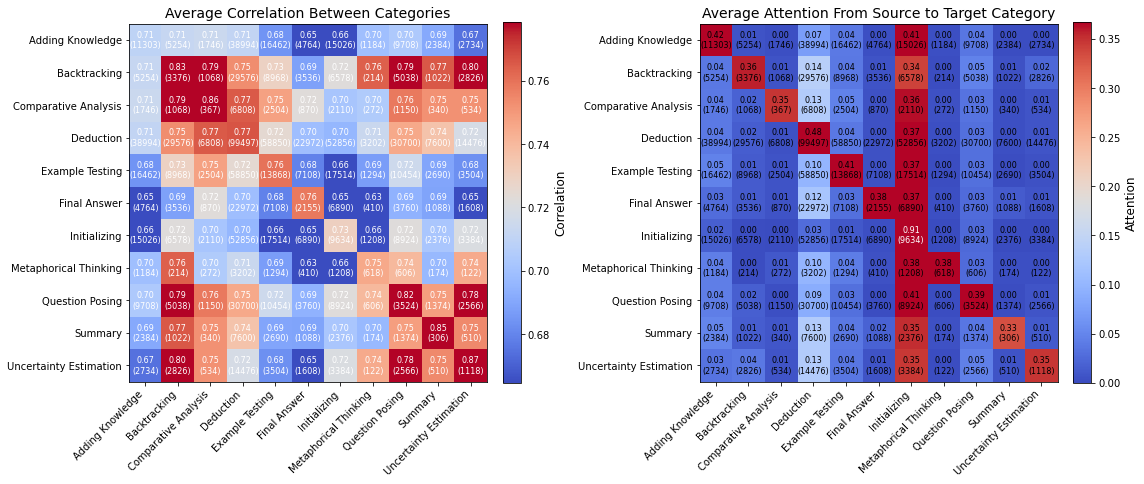

In [22]:
combined_df = create_combined_metrics_df(analysis_dir, layer=31, head='avg')
transition_data = analyze_category_transitions(combined_df)